In [37]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.data import Dataset
import matplotlib.pyplot as plt


In [38]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [39]:
# clear out any old logs
!rm -rf ./logs/ 

In [40]:
signals = [
    'ringtone',
    'random',
    '_background_noise_',
]

In [41]:
training_spectrogram = np.load('training_spectrogram.npz')
validation_spectrogram = np.load('validation_spectrogram.npz')
test_spectrogram = np.load('test_spectrogram.npz')


In [42]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train_cats = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate_cats = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test_cats = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

(array([ 73., 108.,   0.]),
 array([0., 1., 2., 3.]),
 <BarContainer object of 3 artists>)

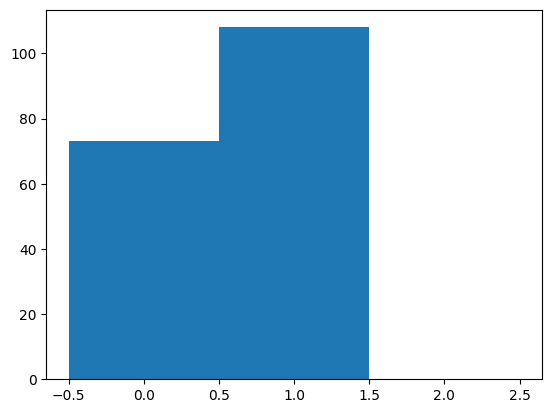

In [43]:
# plot a distribution of the words
plt.hist(Y_train_cats, bins=range(0,len(signals)+1), align='left')

In [44]:
unique, counts = np.unique(Y_train_cats, return_counts=True)
print(unique, counts)
dict(zip([signals[i] for i in unique], counts))



[0 1] [ 73 108]


{'ringtone': 73, 'random': 108}

In [45]:
Y_train = [1 if y == signals.index('random') else 0 for y in Y_train_cats]
Y_validate = [1 if y == signals.index('random') else 0 for y in Y_validate_cats]
Y_test = [1 if y == signals.index('random') else 0 for y in Y_test_cats]

(array([ 73., 108.]), array([0., 1., 2.]), <BarContainer object of 2 artists>)

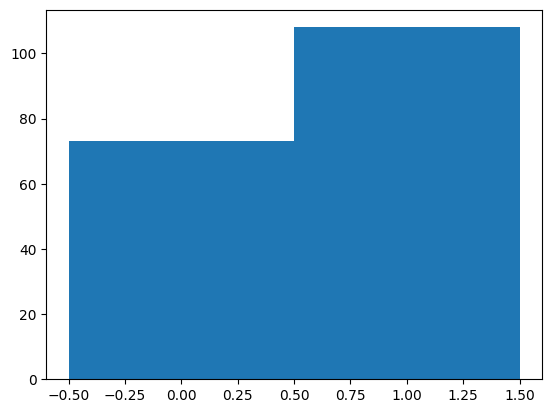

In [46]:
plt.hist(Y_train, bins=range(0,3), align='left')

In [47]:
# create the datasets for training
batch_size = 16

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    len(X_train)
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0])

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

In [48]:
model = Sequential([
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
    Flatten(),
    Dropout(0.2),
    Dense(
        40,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D  (None, 49, 21, 4)         0         
 )                                                               
                                                                 
 conv_layer2 (Conv2D)        (None, 49, 21, 4)         148       
                                                                 
 max_pooling2 (MaxPooling2D  (None, 24, 10, 4)         0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                                 
 dropout_1 (Dropout)         (None, 960)              

In [49]:
epochs=5

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [50]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [51]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoint.model",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=1,
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/5


11/11 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.6534 INFO:tensorflow:Assets written to: checkpoint.model/assets


INFO:tensorflow:Assets written to: checkpoint.model/assets


11/11 [==============================] - 3s 127ms/step - loss: 0.6901 - accuracy: 0.6534 - val_loss: 0.4692 - val_accuracy: 0.9545
Epoch 2/5
11/11 [==============================] - 0s 14ms/step - loss: 0.4379 - accuracy: 0.8807 - val_loss: 0.2814 - val_accuracy: 0.9091
Epoch 3/5
11/11 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8864INFO:tensorflow:Assets written to: checkpoint.model/assets


INFO:tensorflow:Assets written to: checkpoint.model/assets


11/11 [==============================] - 1s 99ms/step - loss: 0.3574 - accuracy: 0.8864 - val_loss: 0.1689 - val_accuracy: 1.0000
Epoch 4/5
11/11 [==============================] - 0s 15ms/step - loss: 0.2652 - accuracy: 0.9261 - val_loss: 0.1619 - val_accuracy: 0.9545
Epoch 5/5
11/11 [==============================] - 0s 13ms/step - loss: 0.1568 - accuracy: 0.9489 - val_loss: 0.1117 - val_accuracy: 1.0000


In [52]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model/assets


INFO:tensorflow:Assets written to: trained.model/assets


In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

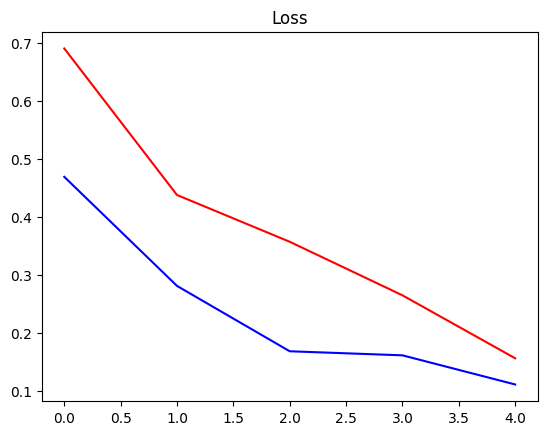

In [54]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

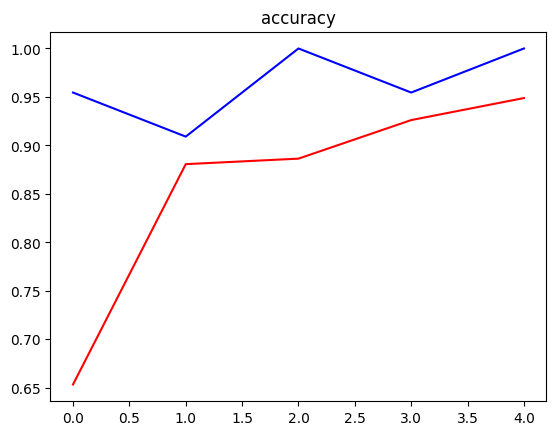

In [55]:
plt.title('accuracy')
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.show()

In [56]:
model2 =  keras.models.load_model("checkpoint.model")

In [57]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=64)

1/1 [==============================] - 0s 144ms/step - loss: 0.3412 - accuracy: 0.9200


In [58]:
predictions = model2.predict_on_batch(X_test)
decision = [1 if p > 0.5 else 0 for p in predictions]
tf.math.confusion_matrix(Y_test, decision)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 8,  2],
       [ 0, 15]], dtype=int32)>

In [59]:
predictions = model2.predict_on_batch(X_test)
decision = [1 if p > 0.9 else 0 for p in predictions]
tf.math.confusion_matrix(Y_test, decision)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 9,  1],
       [ 0, 15]], dtype=int32)>

# Fully train the model

In [60]:
complete_train_X = np.concatenate((X_train, X_validate, X_test))
complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

complete_train_dataset = Dataset.from_tensor_slices((complete_train_X, complete_train_Y)).batch(batch_size).repeat(count=-1).shuffle(300000)

In [61]:
complete_train_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 99, 43, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [62]:
len(complete_train_X) // batch_size,

(14,)

In [63]:
# history = model2.fit(
#     complete_train_dataset,
#     steps_per_epoch=len(complete_train_X) // batch_size,
#     epochs=5
# )

In [64]:
# predictions = model2.predict_on_batch(complete_train_X)
# decision = [1 if p > 0.5 else 0 for p in predictions]
# tf.math.confusion_matrix(complete_train_Y, decision)

In [65]:
# decision = [1 if p > 0.95 else 0 for p in predictions]
# tf.math.confusion_matrix(complete_train_Y, decision)

In [66]:
model2.save("fully_trained.model")

INFO:tensorflow:Assets written to: fully_trained.model/assets


INFO:tensorflow:Assets written to: fully_trained.model/assets
